In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.signal import find_peaks
from scipy.ndimage import uniform_filter1d
import copy
from sklearn.decomposition import PCA
import MEAutility as mu

from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors

from scipy import stats

In [4]:
plt.ion()

### Load Data

In [2]:
# Get all templates from files

folder_name = 'ziad_mearec_templates/'
mea_name = '100MEA75'

#file_name = 'mag_templates_flattened_x15_cell2_rotate_n50_100MEA75.npy'
#file_name = f'mag_templates_flattened_5-25bound_0-2cells_n300_{mea_name}.npy'
#file_name = 'mag_templates_flattened_5-25bound_2-4cells_n300_Neuropixels-128.npy'
#file_name = 'mag_templates_flattened_5-25bound_2-4cells_n300_Neuropixels-128.npy'
file_name = f'mag_templates_flattened_5-25bound_0-2cells_n300_Ziad_Custom_-2_100MEA75_Ex.npy'

with open(folder_name + file_name, 'rb') as f:
    v = np.load(f)[:, :, :]
    bx = np.load(f)[:, :, :]
    by = np.load(f)[:, :, :]
    bz = np.load(f)[:, :, :]
    locs = np.load(f)
    rots = np.load(f)

# addl_files = [f'mag_templates_flattened_5-25bound_2-4cells_n300_{mea_name}.npy',
#               f'mag_templates_flattened_5-25bound_4-6cells_n300_{mea_name}.npy']

addl_files = ['mag_templates_flattened_5-25bound_2-4cells_n300_Ziad_Custom_-2_100MEA75_Ex.npy',
              'mag_templates_flattened_5-25bound_4-6cells_n300_Ziad_Custom_-2_100MEA75_Ex.npy']

for file in addl_files:
    with open(folder_name + file, 'rb') as f:
        v2 = np.load(f)[:, :, :]
        bx2 = np.load(f)[:, :, :]
        by2 = np.load(f)[:, :, :]
        bz2 = np.load(f)[:, :, :]
        locs2 = np.load(f)
        rots2 = np.load(f) 

        v = np.concatenate((v, v2), axis=0)
        bx = np.concatenate((bx, bx2), axis=0)
        by = np.concatenate((by, by2), axis=0)
        bz = np.concatenate((bz, bz2), axis=0)
        locs = np.concatenate((locs, locs2), axis=0)
        rots = np.concatenate((rots, rots2), axis=0)

fields = np.array([v, bx, by, bz])
print("V: ", np.shape(v))
print("Bx: ", np.shape(bx))
print("By: ", np.shape(by))
print("Bz: ", np.shape(bz))
print("Locations: ", np.shape(locs))
print("Rotations: ", np.shape(rots))

V:  (1800, 200, 224)
Bx:  (1800, 200, 224)
By:  (1800, 200, 224)
Bz:  (1800, 200, 224)
Locations:  (1800, 3)
Rotations:  (1800, 3)


In [37]:
def get_E_fields(temps, e_field):
    if e_field == 'Ex':
        Ex1 = temps[:, :, :100]
        Ex2 = temps[:, :, 100:]
        Ex = Ex1 - Ex2
        return Ex
    
    elif e_field == 'Ey':
        idxs2 = np.arange(10, 100)
        idxs1 = np.arange(0, 90)
        Ey = temps[:, :, idxs2] - temps[:, :, idxs1]
        return Ey
    
    elif e_field == 'Ez':
        idxs2 = []
        for i in range(100):
            if i % 10 != 0:
                idxs2.append(i)
        idxs2 = np.array(idxs2)
        idxs1 = idxs2 - 1
        
        Ez = temps[:, :, idxs2] - temps[:, :, idxs1]
        return Ez

### Condition Number Analysis

In [40]:
all_temps = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
#all_temps = [200]
n_per_cell = 300
fields_to_run = [0, 1, 2, 3, 6, 7, 8]

all_s = []

for num_temps in all_temps:
    cell_indices = [0, 1, 2, 3, 4, 5]

    iters = 30

    # Store all condition numbers
    conds = np.zeros((len(fields_to_run), iters))
    
    # Store all singular values
    s_vals = np.zeros((len(fields_to_run), iters, num_temps))
    
    # Create H matrix from flattened recordings for each field
    for j in range(iters):
        print(j)
        
        # Get fields corresponding to specified cells
        num_fields = np.shape(fields)[0]
        total_num_templates = len(cell_indices)*n_per_cell
        num_elecs = np.shape(fields)[2]
        num_tsteps = np.shape(fields)[3]

        sub_fields = np.zeros((num_fields, total_num_templates, num_elecs, num_tsteps))
        for n, cell_idx in enumerate(cell_indices):
            sub_fields[:, n*n_per_cell:(n+1)*n_per_cell] = fields[:, cell_idx*n_per_cell:(cell_idx+1)*n_per_cell]

        idxs = np.random.choice(len(sub_fields[0]), num_temps, replace=False)
        templates = sub_fields[:, idxs]
        print(np.shape(templates))
            
        for k, i in enumerate(fields_to_run):
            
            # Run BxByBz
            if i == 4:
                H = np.transpose(templates[1:4, :, :100], (1, 0, 2, 3))
                H = H.reshape((len(templates[0]), -1))
                
            # Run ByBz
            elif i == 5:
                H = np.transpose(templates[2:4, :, :100], (1, 0, 2, 3))
                H = H.reshape((len(templates[0]), -1))
            
            # Run Ex
            elif i == 6:
                Ex = get_E_fields(templates, 'Ex')
                H = Ex[0].reshape((len(Ex[0]), -1))
            
            # Run Ey
            elif i == 7:
                Ey = get_E_fields(templates, 'Ey')
                H = Ey[0].reshape((len(Ey[0]), -1))
                
            elif i == 8:
                Ez = get_E_fields(templates, 'Ez')
                H = Ez[0].reshape((len(Ez[0]), -1))
                
            # Run single field
            else:
                H = templates[i, :, :100].reshape((len(templates[0]), -1))
                
            H = np.matrix(H / np.linalg.norm(H))
            cov = H * H.getH()
            #print(np.shape(H), np.shape(cov))
            
            u, s, vh = np.linalg.svd(cov)
            cond = s[0]/s[-1]
            print(cond)

            conds[k, j] = cond
            s_vals[k, j] = s
        print("")

    means = np.mean(conds, axis=1)
    stds = np.std(conds, axis=1)
    for q in range(len(means)):
        print(means[q], '\t', stds[q], '\t', str(iters), '\t', end="")
    all_s.append(s_vals)

0
(4, 20, 200, 224)
157.4273637861958
223.0059261380416
272.7681459328225
1759.9663560980175
588.2159038020313
204.61895797772712
235.6510753767084

1
(4, 20, 200, 224)
32.497499575670474
156.95601137804448
368.1740305212036
688.880407320431
129.42324583321607
47.75107634105364
56.96398837354078

2
(4, 20, 200, 224)
160.08924377784874
74.00159401879216
194.52501999817437
1741.4009009658178
935.4825739348714
203.83594509728982
321.80233335238563

3
(4, 20, 200, 224)
53.900002822237084
45.165474413318854
327.20448367556696
1147.0159834194596
502.2355757943705
120.49493177851562
85.50303493358095

4
(4, 20, 200, 224)
76.30524665619622
228.07865397612701
1008.4110854105064
234.08807010238723
464.2452313851046
115.73949100061667
122.68332005062793

5
(4, 20, 200, 224)
203.51311083304302
260.10339832112413
3001.0548596426697
161.66097084272633
4427.394434778724
300.1496161077545
569.7416729866343

6
(4, 20, 200, 224)
251.30153330927698
123.24718262658021
1530.1714802592123
700.2718883353546


(4, 40, 200, 224)
166.86346124131467
321.14939220081277
7891.8187987701185
5272.646558037501
1332.4276715773997
349.73904301106467
283.27761885679394

24
(4, 40, 200, 224)
165.27909587833355
301.14084707222247
516.8736144524609
5628.774713224216
422.1206041322565
226.98799200374293
259.27564777876495

25
(4, 40, 200, 224)
372.81813235297994
157.4714958200343
3829.579844100432
978.6421061418193
4708.879118734185
653.2218635305207
716.4706148454451

26
(4, 40, 200, 224)
161.91278723790197
201.36795966856917
4756.455302105319
365.1273978777475
578.2854555826733
335.3601921290812
283.04017542823664

27
(4, 40, 200, 224)
350.8766434607192
456.9406401879096
3313.3653841317423
2238.5305599816675
5138.4297850720195
500.70820782002687
513.5763390143012

28
(4, 40, 200, 224)
227.66069400869247
298.65012377848797
61890.44334588379
6008.9394381841
2731.3581622101797
458.32950703188857
468.90352140625293

29
(4, 40, 200, 224)
123.75449338300008
277.5111607234445
659.4896419315553
2411.34191615234
7

(4, 80, 200, 224)
910.9986171217021
508.69524862689104
3507.957902942718
20347.22604309724
8312.704974035916
1924.9214127956968
1509.5535175064656

15
(4, 80, 200, 224)
1150.587424526369
744.5787737066225
14317.800810304781
13187.630875527046
4076.2948359932507
3521.26554739283
2277.178348370648

16
(4, 80, 200, 224)
1185.0451626348477
369.90979663533545
44920.85807960911
5661.005999698733
22948.28999156532
2545.4140785959394
2253.2340224014956

17
(4, 80, 200, 224)
492.0432391424446
940.457027385687
10913.086534012717
10414.847810508823
8700.004587944748
932.3316799876543
1281.476871078711

18
(4, 80, 200, 224)
333.71131608544135
474.8511564913556
4881.115986019408
1724.1954833162597
1585.355507494161
671.1197960442178
828.1989322325494

19
(4, 80, 200, 224)
651.1874946854705
732.2753610897257
11555.038200340214
52452.46377559289
5233.376939803424
978.6751330670631
1347.2598168781935

20
(4, 80, 200, 224)
515.4050642699553
769.1216753652236
1063.9868320430412
3861.836270414553
3466.08

(4, 120, 200, 224)
2158.0768978849237
1487.7330631859488
10238.792670049752
54852.597955279314
10331.835608396046
3551.0942422120356
3868.6392771813994

5
(4, 120, 200, 224)
919.1123576568781
1253.746370328507
108728.89943673115
23216.89627326289
9843.302497757817
1492.8060440359654
1465.584136972841

6
(4, 120, 200, 224)
2696.9958857225065
1184.662548237347
41735.860563361566
29051.508880133773
11102.546449452031
4108.775359044456
3484.3827185913465

7
(4, 120, 200, 224)
2373.808820758007
872.4777057642548
78314.2881254806
13123.372796468804
21556.2218438017
4748.868118256607
3606.3882245434966

8
(4, 120, 200, 224)
691.5892166433439
1125.6775750582715
14863.372354935575
56803.28365990622
4706.213612230724
1618.8077649937065
1558.1837010612503

9
(4, 120, 200, 224)
1733.9273559341416
909.6659680181026
24788.699384711337
49255.37949103837
10011.973561311788
4072.15010670244
3054.238147280313

10
(4, 120, 200, 224)
2094.173071000458
1396.7256604739287
12854.303773124931
23094.7854963463

(4, 140, 200, 224)
1893.0484447407975
1652.1791259371942
39549.45069660801
114163.659726686
7086.0463051749075
4763.578428868101
3110.633371157919

27
(4, 140, 200, 224)
5147.866954169116
1588.1896125445644
30772.929246905867
12668.747749956055
11628.186193978874
7795.123936137425
8878.127577250878

28
(4, 140, 200, 224)
2341.2919716307624
2402.084495702949
23328.265867586473
45733.928415879964
7191.417212445875
4613.24462873477
3218.1440126578245

29
(4, 140, 200, 224)
2342.407622568249
2632.84424113264
8091.996047455797
171817.81595029857
12152.030573785394
3634.9685771509535
3315.5654624972162

4194.661487220738 	 2515.611321783617 	 30 	1896.164552020125 	 1239.8659004368258 	 30 	61849.68068115763 	 61933.9230621762 	 30 	88552.89211580432 	 104191.59353778274 	 30 	19674.81217866165 	 13801.705462066077 	 30 	6352.334135772796 	 3128.0162950080057 	 30 	7034.426464717574 	 5477.815717298134 	 30 	0
(4, 160, 200, 224)
2170.3913958107464
1347.986026952256
21333.99538727901
71403.59

27276.61091140705
6658.8275868075925
6567.882455302716

17
(4, 180, 200, 224)
11874.950197886717
2478.4002691090986
30157.182212585147
51269.0146093742
39827.277588784345
20417.2995960118
15670.83933147387

18
(4, 180, 200, 224)
10984.641236041707
3507.6328129570434
47642.9202749228
138271.72842008946
62787.29806300639
21630.815567891113
21083.1890654327

19
(4, 180, 200, 224)
4952.746878827377
2422.9695446383535
29229.985136780244
208456.62828718135
31394.882579727615
7457.73753116056
7984.443425299235

20
(4, 180, 200, 224)
7305.667176478779
2250.077736455895
118832.20737427619
152466.1162309955
49348.05504642556
12739.027944137706
14156.228183636305

21
(4, 180, 200, 224)
4338.242051294476
2338.0926534128675
135063.19398876923
76428.81520741635
23384.23199423319
7617.987568710247
11122.888721400568

22
(4, 180, 200, 224)
5918.982387210031
3166.5623411000497
12384.09375440638
108394.06262473305
26945.54206601334
11848.203138211109
11519.26240373826

23
(4, 180, 200, 224)
4782.9034031

### Singular Value Analysis

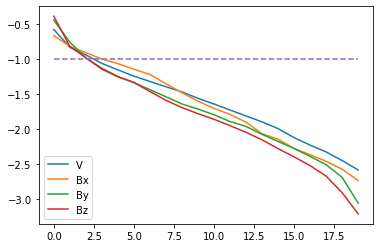

In [44]:
mean_s = np.mean(all_s[0][0], axis=0)
plt.plot(np.log10(mean_s))
mean_s = np.mean(all_s[0][1], axis=0)
plt.plot(np.log10(mean_s))
mean_s = np.mean(all_s[0][2], axis=0)
plt.plot(np.log10(mean_s))
mean_s = np.mean(all_s[0][3], axis=0)
plt.plot(np.log10(mean_s))

# Plot noise
snr = 10
snr = snr/10
noise = np.zeros(np.shape(mean_s)) - snr

plt.plot(noise, '--')

plt.legend(['V', 'Bx', 'By', 'Bz'])

In [52]:
idx = 3
vals = np.log10(all_s[0][idx])
means = np.mean(vals, axis=0)
stds = np.std(vals, axis=0)

for i in range(len(means)):
    print(means[i], '\t', stds[i], '\t', str(30))

-1.228806178179067 	 0.11797936076939669 	 30
-1.373383317051059 	 0.07347743244310125 	 30
-1.466780839432803 	 0.07507222406032489 	 30
-1.5481669294354132 	 0.057502832453159736 	 30
-1.5977219225739143 	 0.042907060718350376 	 30
-1.6340686112717178 	 0.036562546273022266 	 30
-1.663737920463884 	 0.03397302077446728 	 30
-1.6867661019061646 	 0.031139081733718574 	 30
-1.7097678254864477 	 0.029923317582859404 	 30
-1.7338135791288802 	 0.03394404215229788 	 30
-1.7543506983725756 	 0.031762443827857666 	 30
-1.7762739078589225 	 0.02978104869787341 	 30
-1.793772048959751 	 0.02821769251048284 	 30
-1.8152095759849727 	 0.026160172069944875 	 30
-1.833737296729077 	 0.027268384070807075 	 30
-1.853399164113273 	 0.02580430230699713 	 30
-1.871571275499152 	 0.027587765014801702 	 30
-1.8833485888675405 	 0.024395618933772498 	 30
-1.9045954606000157 	 0.025689998127046944 	 30
-1.9173539261125285 	 0.026217959960709716 	 30
-1.9347950892186854 	 0.03211199894252917 	 30
-1.948125

In [30]:
np.shape()

(20, 4, 100, 224)

In [16]:
mea = mu.return_mea('100MEA75')

In [17]:
mea.positions

array([[   0. , -337.5, -337.5],
       [   0. , -337.5, -262.5],
       [   0. , -337.5, -187.5],
       [   0. , -337.5, -112.5],
       [   0. , -337.5,  -37.5],
       [   0. , -337.5,   37.5],
       [   0. , -337.5,  112.5],
       [   0. , -337.5,  187.5],
       [   0. , -337.5,  262.5],
       [   0. , -337.5,  337.5],
       [   0. , -262.5, -337.5],
       [   0. , -262.5, -262.5],
       [   0. , -262.5, -187.5],
       [   0. , -262.5, -112.5],
       [   0. , -262.5,  -37.5],
       [   0. , -262.5,   37.5],
       [   0. , -262.5,  112.5],
       [   0. , -262.5,  187.5],
       [   0. , -262.5,  262.5],
       [   0. , -262.5,  337.5],
       [   0. , -187.5, -337.5],
       [   0. , -187.5, -262.5],
       [   0. , -187.5, -187.5],
       [   0. , -187.5, -112.5],
       [   0. , -187.5,  -37.5],
       [   0. , -187.5,   37.5],
       [   0. , -187.5,  112.5],
       [   0. , -187.5,  187.5],
       [   0. , -187.5,  262.5],
       [   0. , -187.5,  337.5],
       [  